# Utils

## Install Prerequisites

In [ ]:
pip install pyspellchecker

## Import Libraries

In [ ]:
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from spellchecker import SpellChecker

## Download Packages

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Implement Functions

In [ ]:
def correct_types(df, columns):
    """
    Preprocess the specified columns in a DataFrame by replacing NaN values with an empty string
    and converting non-string values to string objects.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - column (str): The column to be preprocessed. Default is 'SO_Omschrijving'.

    Returns:
    - pd.DataFrame: The DataFrame with the specified column preprocessed.
    """

    df[columns] = df[columns].fillna('')
    df[columns] = df[columns].astype(str)
    return df

def replace_punctuation_text(text):
    """
    Replace punctuation in the input text.

    Parameters:
    - text (str): The input text in which punctuation will be replaced.

    Returns:
    - str: The input text with punctuation replaced.
    """
    # Replace "'s" with empty space.
    text = text.replace("'s", '')

    # Create a translation table to replace '.' and "'" with empty space, and other punctuation with spaces.
    translator = str.maketrans({'.': '', "'": '', **{p: ' ' for p in string.punctuation if p not in ['.', "'"]}})

    cleaned_text = text.translate(translator)

    return cleaned_text

def replace_punctuation(df, columns):
    """
    Replaces specific punctuation in the specified columns of a DataFrame.

    This function is designed to clean textual data in the specified columns of a DataFrame by:
    - Replacing occurrences of "'s" with an empty string.
    - Replacing periods (.) and apostrophes (') with an empty string.
    - Replacing other punctuation marks with a space.

    Args:
        df (pd.DataFrame): The DataFrame containing the columns to be cleaned.
        columns (list or str): The column name(s) of the DataFrame where the replacements should be applied.

    Returns:
        pd.DataFrame: The DataFrame with the specified columns cleaned of certain punctuation marks.
    """
    # Replace "'s" with an empty string in the specified columns.
    df[columns] = df[columns].replace("'s", '', regex=True)

    # Create a translation table to replace '.' and "'" with empty space,
    # and other punctuation with spaces.
    translator = str.maketrans({
        '.': '',                # Remove periods
        "'": '',                # Remove apostrophes
        **{p: ' ' for p in string.punctuation if p not in ['.', "'"]}  # Replace other punctuation with space
    })

    # Apply the translation table to each element in the specified columns.
    df[columns] = df[columns].applymap(lambda x: x.translate(translator))

    return df

def remove_numerical_values_text(text):
    """
    Remove numbers and model-related patterns from the input text.

    Parameters:
    - text (str): The input text from which numbers and model-related patterns will be removed.

    Returns:
    - str: The input text with numbers and model-related patterns removed.
    """
    # Remove standalone numbers with optional floating points; such as 154, 99.31.
    text = re.sub(r'\b\d+(\.\d+)?\b', '', text)

    # Remove ordinal numbers; such as 1e, 2ste, 3de, 4e.
    text = re.sub(r'\b\d+(e|ste|de|e)\b', '', text)

    # Remove numerical quantifiers; such as 1x OH.
    text = re.sub(r'\b\d+[xX]\b', '', text)

    return text

def remove_numerical_values(df, columns):
    """
    Removes various forms of numerical values from the specified columns in a DataFrame.

    This function cleans textual data in the specified columns by:
    - Removing standalone numbers with optional floating points (e.g., 154, 99.31).
    - Removing ordinal numbers commonly used in Dutch (e.g., 1e, 2ste, 3de, 4e).
    - Removing numerical quantifiers with 'x' (e.g., 1x, 2X).

    Args:
        df (pd.DataFrame): The DataFrame containing the columns to be cleaned.
        columns (list or str): The column name(s) of the DataFrame where the numerical values should be removed.

    Returns:
        pd.DataFrame: The DataFrame with the specified columns cleaned of numerical values.
    """
    # Remove standalone numbers with optional floating points (e.g., 154, 99.31).
    df[columns] = df[columns].applymap(lambda x: re.sub(r'\b\d+(\.\d+)?\b', '', x))

    # Remove ordinal numbers (e.g., 1e, 2ste, 3de, 4e).
    df[columns] = df[columns].applymap(lambda x: re.sub(r'\b\d+(e|ste|de)\b', '', x))

    # Remove numerical quantifiers (e.g., 1x, 2X).
    df[columns] = df[columns].applymap(lambda x: re.sub(r'\b\d+[xX]\b', '', x))

    return df

def stemize(text):
    """
    Perform stemming on the input text using the Dutch Snowball Stemmer.

    Parameters:
    - text (str): The input text to be stemmed.

    Returns:
    str: The stemmed text.

    Example:
    >>> stemize("This is an example text for stemming.")
    'thi is an exampl text for stem.'
    """
    stemmer = SnowballStemmer("dutch")
    tokens = word_tokenize(text)
    text = ' '.join([stemmer.stem(token) for token in tokens])
    return text

def normalize_lookups():
    """
    Normalize and preprocess the global lookup lists.

    This function performs the following operations on each global lookup list:
    1. Orders lookup lists by length in descending order.
    2. Initializes the Dutch Snowball Stemmer.
    3. Replaces punctuations using the `replace_punctuation` function.
    4. Removes numerical values using the `remove_numerical_values` function.
    5. Applies stemming using the `stemize` function.
    6. Converts the resulting list to a set.

    Note: The original lookup lists are modified in-place.

    Returns:
    None
    """
    # Get all lookup lists using regular expression.
    lookup_lists = [var for var in globals() if re.match(r'^lookup_', var)]
    lookup_ventilation_lists = [var for var in globals() if re.match(r'^sublookup_', var)]

    for lookup_list_name in lookup_lists:

        lookup_list = globals()[lookup_list_name]

        # Replace punctuations, remove numerical values, and apply stemming.
        normalized_list = [stemize(remove_numerical_values_text(replace_punctuation_text(word))) for word in lookup_list]

        # Convert to set.
        lookup_list.clear()
        lookup_list.extend(set(normalized_list))

    for lookup_list_name in lookup_ventilation_lists:

        lookup_list = globals()[lookup_list_name]

        # Replace punctuations, remove numerical values, and apply stemming.
        normalized_list = [stemize(remove_numerical_values_text(replace_punctuation_text(word))) for word in lookup_list]

        # Convert to set.
        lookup_list.clear()
        lookup_list.extend(set(normalized_list))

def group_modules(description, lookup_lists):
    """
    Classifies a description into a module type based on predefined lookup lists.

    This function checks if the given description contains any words from a set of lookup lists
    and assigns a module type accordingly. The lookup lists are accessed dynamically using their
    names, and the corresponding module type is identified using a separate mapping.

    Args:
        description (str): The text description to be classified.
        lookup_lists (list of str): A list of lookup list names to check against the description.

    Returns:
        str: The identified module type name if a match is found; otherwise, 'Other'.
    """
    # Convert the description to lowercase to ensure case-insensitive matching.
    description = description.lower()

    # Iterate through each lookup list name in the provided list.
    for lookup_list_name in lookup_lists:
        # Access the actual lookup list using the global variable name.
        lookup_list = globals().get(lookup_list_name)

        # Check if any word in the lookup list is present in the description.
        for word in lookup_list:
            if word.lower() in description:
                # Map the lookup list name to its corresponding module type.
                type_name = module_names[lookup_list_name.split('_')[1]]
                return type_name  # Return the matched module type.

    # Return 'Other' if no matching word is found in the lookup lists.
    return 'Other'

def rules_to_coordinates(rules):
    """
    Convert association rules to coordinates.

    Parameters:
    - rules (pd.DataFrame): DataFrame containing association rules with 'antecedents', 'consequents', and other columns.

    Returns:
    - pd.DataFrame: DataFrame with 'antecedent', 'consequent', and 'rule' columns representing coordinates.
    """

    # Extract the first item from antecedents and consequents.
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])

    # Assign rule index to a new column 'rule'.
    rules['rule'] = rules.index

    # Select relevant columns for coordinates.
    coords = rules[['antecedent', 'consequent', 'rule']]

    return coords

def contains_word_regex(sentence, target_word):
    """
    Check if a given word is present in a sentence using regex.

    Parameters:
    - sentence (str): The input sentence to check.
    - target_word (str): The word to look for in the sentence.

    Returns:
    - bool: True if the word is found, False otherwise.
    """
    # Construct a regex pattern to match the whole word, case-insensitive.
    pattern = r'\b' + re.escape(target_word) + r'\b'

    # Use re.search to find the pattern in the sentence.
    match = re.search(pattern, sentence, flags=re.IGNORECASE)

    # Return True if a match is found, False otherwise.
    return bool(match)

def convert_str_to_set(itemset_str):
    """
    Converts a comma-separated string into a set of items.

    This function takes a string containing items separated by commas,
    strips any surrounding whitespace from each item, and returns a set
    containing the unique items. This is useful for converting textual
    representations of itemsets into Python set objects for further analysis.

    Args:
        itemset_str (str): A string of items separated by commas.

    Returns:
        set: A set containing the stripped items from the input string.
    """
    # Split the string by commas and strip whitespace from each item.
    items = [item.strip() for item in itemset_str.split(',')]

    # Convert the list of items to a set to ensure uniqueness.
    return set(items)

def get_season(month):
    """
    Determine the season corresponding to a given month.
    Args:
        month (int): The month as an integer (1 for January, 2 for February, ..., 12 for December).
    Returns:
        str: The season name corresponding to the input month:
            - 'Winter' for December (12), January (1), February (2)
            - 'Spring' for March (3), April (4), May (5)
            - 'Summer' for June (6), July (7), August (8)
            - 'Fall' for September (9), October (10), November (11)
    Raises:
        ValueError: If the input month is not between 1 and 12.
    """
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        raise ValueError("Month must be an integer between 1 and 12.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Define Lookup Tables

In [ ]:
lookup_ventilation = [
    "lbk",
    "luchtbehandeling",
    "luchtbehandelen",
    "luchbehandeling",
    "luchtbehandeling",
    "ventilatiesysteem",
    "ventilatie",
    "luchtklep",
    "stoombevochtiger",
    "stoombevochtiging",
    "bevochtiger",
    "toevoerventilator",
    "afvoerventilator",
    "ventilatormotor",
    "dakventilatoren",
    "Dakventilator",
    "toevoer ventilator",
    "dak ventilatoren",
    "Afzuiventilator",
    "wiel",
    "afzuigvent",
    "V-snaren",
    "V snaren",
    "filters",
    "snaarbreuk",
    "condensafvoer",
    "condensor",
    "filter",
    "Luchtbeh",
    "LBH",
    "vorst",
    "verwarmingsbatterij",
    "stoomvochtiger",
    "luchtdebiet",
    "luchtzakken",
    "fancoil",
    "fan coil",
    "fan-coil"
]

lookup_cooling = [
    "airco",
    "drogekoeler",
    "koelmachine",
    "koeling",
    "KM",
    "koelunit",
    "koelinstallatie",
    "topcooling",
    "gkw",
    "koeltoren",
    "chillers",
    "dry-cooler",
    "drycooler",
    "koelplafond",
    "koelklep",
    "koelwaterpomp",
    "carrier",
    "koel-unit",
    "DX koeler",
    "DX-koeler",
    "draaikoeler",
    "condensventilator",
    "chiller",
    "koelventilator",
    "Condensorventilator",
    "condensor",
    "split unit",
    "split-unit",
    "splitunit"
]

lookup_heating = [
    "ketel",
    "CV",
    "c.v.",
    "c.v",
    "Kachel",
    "verwarming",
    "radiatoren",
    "radiator",
    "vloerverwarming",
    "rookgasventilator"
]

lookup_fireSafety = [
    "brandmeld",
    "rookmelder",
    "branddeur",
    "brandklep",
    "brandweer",
    "brandhaspel",
    "brandblus",
    "ontruiming",
    "Brandventilatoren",
    "trappenhuis"
]

lookup_entrance = [
    "toegangspoort",
    "tourniqet",
    "paslezer","tourniquet",
    "tourniqeut",
    "tourniqut",
    "toegang",
    "Toerniqet",
    "tourniget",
    "garagedeur",
    "schuifhek",
    "slagboom"
]

lookup_shading = [
    "zonwering",
    "zonneschermen",
    "zonnewering"
]

lookup_sanitary = [
    "toilet",
    "WC",
    "urinoir",
    "wastafel",
    "sanitair",
    "wasbak",
    "afvoer"
]

lookup_heatPump = [
    "warmtepomp",
    "warmte pomp",
    "WKO"
]

lookup_lighting = [
    "verlichting",
    "lamp",
    "Tl-buis",
    "licht",
    "tlarmatuur",
    "tlbuizen",
    "armatuur",
    "armaturen",
    "armanturen"
]

lookup_elevator = [
    "Lift"
]

lookup_wkk = [
    "WKK"
]

lookup_bms = [
    "GBS",
    "Data",
    "logger",
    "lon",
    "BMC",
    "priva",
    "software",
    "regeling",
    "hardware",
    "regelkast",
    "RK 1",
    "rk5",
    "rk2",
    "RK5",
    "rk3",
    "Rk 3",
    "rk4",
    "rk 4",
    "rk1",
    "rk2",
    "rk6",
    "rk 6",
    "RK7",
    "sensor",
    "regelaar",
    "opnemer",
    "thermostaat",
    "meting",
    "onderstation",
    "Kloktijden",
    "kastventilatoren",
    "kastventilatoren",
    "kastventilator",
    "Kastventilator"
]

lookup_waterDistribution = [
    "regelklep",
    "driewegklep",
    "TSA",
    "Warmtewisselaar",
    "pomp",
    "hydrofoor",
    "expansie",
    "drukvat",
    "waterleiding",
    "3wegklep",
    "transportnet"
]

lookup_office = [
    "werkvoorbereiding",
    "Contractbeheerder",
    "materiaal",
    "Onderaanneming",
    "Werkvoorbereider",
    "kantoor",
    "Materiaalbon",
    "Urenbon",
    "Contractbegeleiding",
    "Contractbeheer",
    "overleg",
    "Meet-enregeltechniek",
    "Inlenen",
    "Weekplanning",
    "calculatie",
    "Onderaannemering",
    "contractmanager",
    "Contractmanagement",
    "Onderaannemer"
]

lookup_domesticWater = [
    "warm water",
    "ww",
    "w.w.",
    "w.w",
    "warmtapwater",
    "warmwater",
    "boiler"
]

lookup_faultRedemption = [
    "Storingsafkoop",
    "Afkoopstoringen",
    "Verrekening afkoop"
]

lookup_regularMaintenance = [
    "onderhoud",
    "inspectie",
    "OH",
    "OHD",
    "controle",
    "Preventief",
    "testen",
    "Bedrijfvoering",
    "Bedrijfsvoering"
]

lookup_complaints = [
    "klachten",
    "klacht",
    "te warm",
    "tekoud",
    "luchtvochtigheid",
    "klimaatbeheersing",
    "klimaat",
    "teheet",
    "benauwd",
    "tocht",
    "R.V.",
    "ergkoud",
    "RV telaag",
    "lekkage",
    "Ruimtevochtigheid",
    "erg warm",
    "erg koud"
]

module_names = {
    "complaints": "Complaints",
    "regularMaintenance": "Regular Maintenance",
    "faultRedemption": "Fault Redemption",
    "domesticWater": "Domestic Water",
    "office": "Office",
    "waterDistribution": "Water Distribution",
    "bms": "BMS",
    "wkk": "WKK",
    "elevator": "Elevator",
    "lighting": "Lighting",
    "heatPump": "Heat Pump",
    "sanitary": "Sanitary",
    "fireSafety": "Fire Safety",
    "shading": "Shading",
    "entrance": "Entrance",
    "ventilation": "Ventilation",
    "heating": "Heating",
    "cooling": "Cooling",
}

normalize_lookups()

list_lookups = [var for var in globals() if re.match(r'^lookup_', var)]
list_lookups = sorted(list_lookups, key=lambda x: len(globals()[x]), reverse=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Reading

In [ ]:
# Define the path to the dataset here.
path = '/content/drive/MyDrive/Colab Notebooks/Navision Serviceorder data.xlsx'

df_so = pd.read_excel(path)
df_so.reset_index(drop=True, inplace=True)
columns_to_select = ['SO_Omschrijving', 'Probleemtekst', 'Oorzaaktekst', 'Oplossingstekst', 'SO_Orderdatum (Begindatum)', 'Order technisch gereed (Einddatum)', 'Factuurkosten SO']
df_so = df_so[columns_to_select]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Exploratory Data Analysis

## Statistical Analysis

In [ ]:
df_so.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16074 entries, 0 to 16073
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   SO_Omschrijving                     16064 non-null  object        
 1   Probleemtekst                       15998 non-null  object        
 2   Oorzaaktekst                        16029 non-null  object        
 3   Oplossingstekst                     16059 non-null  object        
 4   SO_Orderdatum (Begindatum)          16074 non-null  datetime64[ns]
 5   Order technisch gereed (Einddatum)  14972 non-null  datetime64[ns]
 6   Factuurkosten SO                    16074 non-null  float64       
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 879.2+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_so.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,SO_Orderdatum (Begindatum),Order technisch gereed (Einddatum),Factuurkosten SO
count,16074,14972,16074.000000
mean,2018-10-30 14:51:22.642777088,2018-12-12 15:24:28.661501440,278.814410
min,2015-01-02 00:00:00,2015-01-05 00:00:00,-2111.500000
25%,2016-09-07 00:00:00,2016-10-08 12:00:00,76.480000
50%,2018-09-26 00:00:00,2018-12-01 00:00:00,171.395000
75%,2020-10-15 00:00:00,2020-11-27 00:00:00,328.075000
max,2023-11-30 00:00:00,2023-11-30 00:00:00,61924.960000
std,NaN,NaN,663.642489


## Data Cleaning

In [ ]:
textual_columns = ['SO_Omschrijving', 'Probleemtekst', 'Oorzaaktekst', 'Oplossingstekst']

# Correct cell value types.
df_so_cleaned = correct_types(df_so.copy(), textual_columns)

# Replace punctuations.
df_so_cleaned = replace_punctuation(df_so_cleaned, textual_columns)

# Remove numerical values.
df_so_cleaned = remove_numerical_values(df_so_cleaned, textual_columns)

# Remove Dutch stop words.
stop_words = set(stopwords.words('dutch'))
stop_words.add('via')
stop_words.remove('niet')
df_so_cleaned[textual_columns] = df_so_cleaned[textual_columns].applymap(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Stemize the text.
df_so_cleaned[textual_columns] = df_so_cleaned[textual_columns].applymap(stemize)

df_so_cleaned.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-4-c7f656a0af14>:66: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns] = df[columns].applymap(lambda x: x.translate(translator))
<ipython-input-4-c7f656a0af14>:108: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns] = df[columns].applymap(lambda x: re.sub(r'\b\d+(\.\d+)?\b', '', x))
<ipython-input-4-c7f656a0af14>:111: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns] = df[columns].applymap(lambda x: re.sub(r'\b\d+(e|ste|de)\b', '', x))
<ipython-input-4-c7f656a0af14>:114: FutureWarning: Dat

,SO_Omschrijving,Probleemtekst,Oorzaaktekst,Oplossingstekst,SO_Orderdatum (Begindatum),Order technisch gereed (Einddatum),Factuurkosten SO
0,storing stoombevochtiger ruimt,grag storing stoombevochtiger doorgevenhet bet...,niet duidelijk,cod 5b stat drainag foutendiver component geco...,2022-02-16,2022-02-17,154.18
1,wasbak pantry ruimt loopt slecht,wasbak pantry ruimt derd verdiep loopt slecht ...,technisch gebrek,afvoer pantry erg vervuild zie foto schoongema...,2022-03-04,2022-03-04,229.58
2,storing bevochtiger lbk link,storing bevochtiger lbk linksafwijk w,technisch gebrek,ingebeld storing geaccepteerd vanaf afstand ni...,2022-03-07,2022-03-08,188.14
3,afzuig schakelar werkt niet keuk,afzuig schakelar werkt niet keukenafwijk w,technisch gebrek,afzuig kap kookeiland werkt niet regelkast gek...,2022-05-23,2022-05-23,250.17
4,snaarbreuk afzuigvent lbk recht,gegenereerd gbsdatum tijd 50system sl138278 ge...,technisch gebrek,gaarn locatie beoordel herstellenfunctionel he...,2022-06-30,2022-07-04,447.16


## Data Annotation

In [ ]:
# Apply the 'group_modules' function to categorize each service order (SO) description into a main subsystem (module).
# The 'target' column will store the assigned subsystem label for each service order based on the lookup tables.
df_so_cleaned['target'] = df_so_cleaned['SO_Omschrijving'].apply(lambda description: group_modules(str(description), list_lookups))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


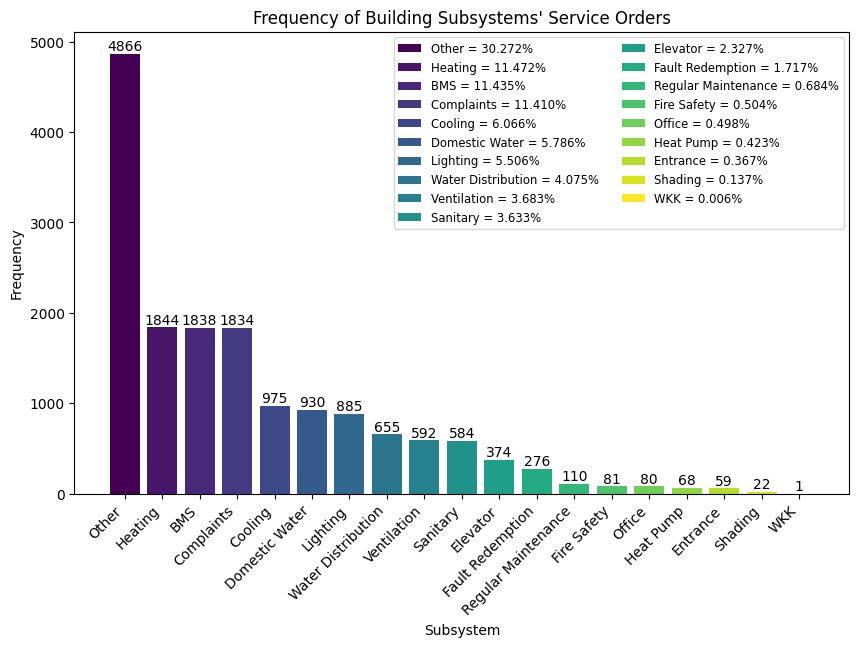

In [ ]:
# Calculate the counts for each target category.
target_counts = df_so_cleaned["target"].value_counts()

# Calculate the total number of samples.
total_samples = len(df_so_cleaned)

# Plotting the bar chart.
plt.figure(figsize=(10, 6))
bars = plt.bar(target_counts.index, target_counts, color=plt.cm.viridis(np.linspace(0, 1, len(target_counts))))
plt.title("Frequency of Building Subsystems' Service Orders")
plt.xlabel("Subsystem")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.yticks(minor=True)

# Add counts on top of the bars.
for bar, count in zip(bars, target_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 1, str(count), ha='center', va='bottom')

# Calculate and format percentages for legend labels.
percentages = [(f"{category} = {count/total_samples*100:.3f}%") for category, count in target_counts.items()]

# Add legend with custom labels.
plt.legend(bars, percentages, loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize='small')

plt.savefig('/content/drive/MyDrive/Kropman/figures/Annotation (Classification)/module_categories.png')
plt.show()

## Keep Original Description Column (SO_Omschrijving)

In [ ]:
df_so_cleaned['original_sentence'] = df_so['SO_Omschrijving']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Get Ventilation Data

In [ ]:
df_so_cleaned_ventilation = df_so_cleaned[df_so_cleaned['target'] == 'Ventilation']

df_so_cleaned_ventilation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 592 entries, 0 to 16070
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   SO_Omschrijving                     592 non-null    object        
 1   Probleemtekst                       592 non-null    object        
 2   Oorzaaktekst                        592 non-null    object        
 3   Oplossingstekst                     592 non-null    object        
 4   SO_Orderdatum (Begindatum)          592 non-null    datetime64[ns]
 5   Order technisch gereed (Einddatum)  552 non-null    datetime64[ns]
 6   Factuurkosten SO                    592 non-null    float64       
 7   target                              592 non-null    object        
 8   original_sentence                   592 non-null    object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 46.2+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_so_cleaned_ventilation.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,SO_Omschrijving,Probleemtekst,Oorzaaktekst,Oplossingstekst,SO_Orderdatum (Begindatum),Order technisch gereed (Einddatum),Factuurkosten SO,target,original_sentence
0,storing stoombevochtiger ruimt,grag storing stoombevochtiger doorgevenhet bet...,niet duidelijk,cod 5b stat drainag foutendiver component geco...,2022-02-16,2022-02-17,154.18,Ventilation,storing stoombevochtiger ruimte 4.29
2,storing bevochtiger lbk link,storing bevochtiger lbk linksafwijk w,technisch gebrek,ingebeld storing geaccepteerd vanaf afstand ni...,2022-03-07,2022-03-08,188.14,Ventilation,Storing bevochtiger van LBK-Links.
4,snaarbreuk afzuigvent lbk recht,gegenereerd gbsdatum tijd 50system sl138278 ge...,technisch gebrek,gaarn locatie beoordel herstellenfunctionel he...,2022-06-30,2022-07-04,447.16,Ventilation,Snaarbreuk afzuigvent. LBK rechts
9,lbk recht stoomomvormer 100sb01,gegenereerd gbsdatum tijd 25system sl138278 ge...,technisch gebrek,insit remot ingebeld project volgend geconstat...,2023-02-15,2023-02-16,133.81,Ventilation,LBK Rechts Stoomomvormer 04_100SB01
16,stoomomvormer lbk recht,datum tijd 39onderstation 4omschrijv stoomomvo...,technisch gebrekafviervlotter blijft hang kalk...,insiteremot ingebeld project volgend geconstat...,2023-04-28,2023-05-01,366.47,Ventilation,Stoomomvormer LBK-Rechts.


# Frequency Analysis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


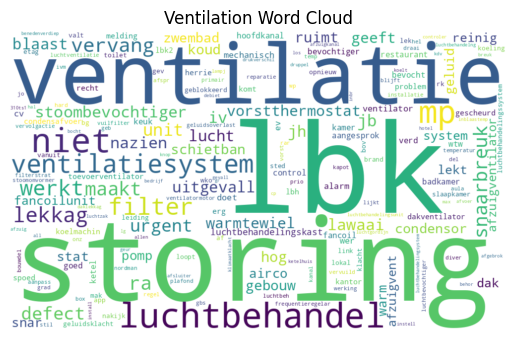

In [ ]:
# Extract the 'SO_Omschrijving' (service order description) for all service orders categorized under 'Ventilation'.
# Store them as a list for further processing in text analysis.
corpus_ventilation = df_so_cleaned_ventilation[df_so_cleaned_ventilation['target'] == 'Ventilation']['SO_Omschrijving'].tolist()

# Initialize a CountVectorizer to convert the heating-related descriptions into a document-term matrix (DTM).
# We are specifying that we only want to extract unigrams (individual words) with ngram_range=(1, 1).
vectorizer_ventilation = CountVectorizer(ngram_range=(1, 1))

# Fit the vectorizer to the corpus and transform it into a DTM (a matrix of word counts).
dtm_ventilation = vectorizer_ventilation.fit_transform(corpus_ventilation)

# Retrieve the feature names (terms) from the vectorizer (i.e., the words in the DTM).
terms_ventilation = vectorizer_ventilation.get_feature_names_out()

# Convert the DTM into a DataFrame where each column corresponds to a word and each row represents a service order.
dtm_ventilation = pd.DataFrame(dtm_ventilation.toarray(), columns=terms_ventilation)

# Calculate the frequency of each term by summing over the columns of the DTM.
term_frequencies_ventilation = dtm_ventilation.sum()

# Generate a word cloud based on the term frequencies for the heating-related service orders.
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_ventilation)

# Display the word cloud.
plt.title('Ventilation Word Cloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Save the generated word cloud image to the specified directory. Change this in case of need!
plt.savefig('/content/drive/MyDrive/Kropman/figures/EDA/ventilation_terms_word_cloud.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-16-f837d2cdcbbc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_so_cleaned_ventilation['Year'] = df_so_cleaned_ventilation['SO_Orderdatum (Begindatum)'].dt.year


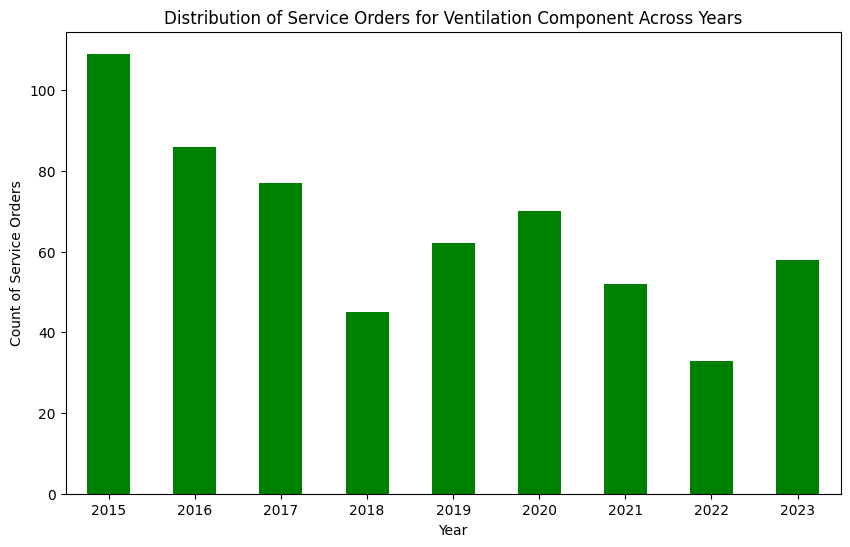

In [ ]:
# Extract the year from the 'SO_Orderdatum (Begindatum)' column (service order start date) for each ventilation-related service order.
# Store the extracted year in a new 'Year' column within the ventilation service orders DataFrame.
df_so_cleaned_ventilation['Year'] = df_so_cleaned_ventilation['SO_Orderdatum (Begindatum)'].dt.year

# Count the number of service orders for each year and sort the counts by year in ascending order.
year_counts = df_so_cleaned_ventilation['Year'].value_counts().sort_index()

# Create a bar plot to visualize the distribution of service orders across different years for the ventilation component.
plt.figure(figsize=(10, 6))  # Set the figure size for the plot.
year_counts.plot(kind='bar', color='green')  # Plot the counts as a bar plot with green bars.
plt.xlabel('Year')  # Label the x-axis as 'Year'.
plt.ylabel('Count of Service Orders')  # Label the y-axis as 'Count of Service Orders'.
plt.title('Distribution of Service Orders for Ventilation Component Across Years')  # Set the title of the plot.
plt.xticks(rotation=0)  # Ensure the x-axis labels (years) are not rotated.

# Save the plot as a PNG image. Change the output path in case of need!
plt.savefig('/content/drive/MyDrive/Kropman/figures/Frequency/ventilation/yearly_distribution.png')
plt.show()  # Display the plot.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-17-1ece71bab5ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_so_cleaned_ventilation['Month'] = df_so_cleaned_ventilation['SO_Orderdatum (Begindatum)'].dt.month


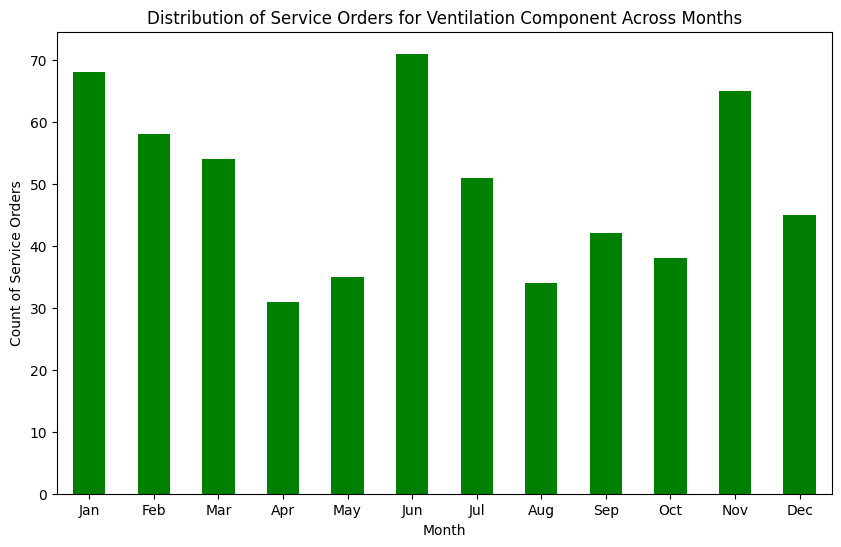

In [ ]:
# Preprocessing: Extracting the month from the 'SO_Orderdatum (Begindatum)' datetime column for each ventilation-related service order.
df_so_cleaned_ventilation['Month'] = df_so_cleaned_ventilation['SO_Orderdatum (Begindatum)'].dt.month

# Counting the occurrences of service orders for each month and sorting the counts by month in ascending order.
month_counts = df_so_cleaned_ventilation['Month'].value_counts().sort_index()

# Create a bar plot to visualize the distribution of service orders across different months for the ventilation component.
plt.figure(figsize=(10, 6))  # Set the figure size for the plot.
month_counts.plot(kind='bar', color='green')  # Plot the counts as a bar plot with green bars.
plt.xlabel('Month')  # Label the x-axis as 'Month'.
plt.ylabel('Count of Service Orders')  # Label the y-axis as 'Count of Service Orders'.
plt.title('Distribution of Service Orders for Ventilation Component Across Months')  # Set the title of the plot.

# Set x-axis labels for the months (Jan to Dec) and ensure the labels are not rotated.
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)

# Save the plot as a PNG image. Change the output path in case of need!
plt.savefig('/content/drive/MyDrive/Kropman/figures/Frequency/ventilation/monthly_distribution.png')

plt.show()  # Display the plot.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-18-b26f7826a5b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_so_cleaned_ventilation['Season'] = df_so_cleaned_ventilation['Month'].apply(get_season)


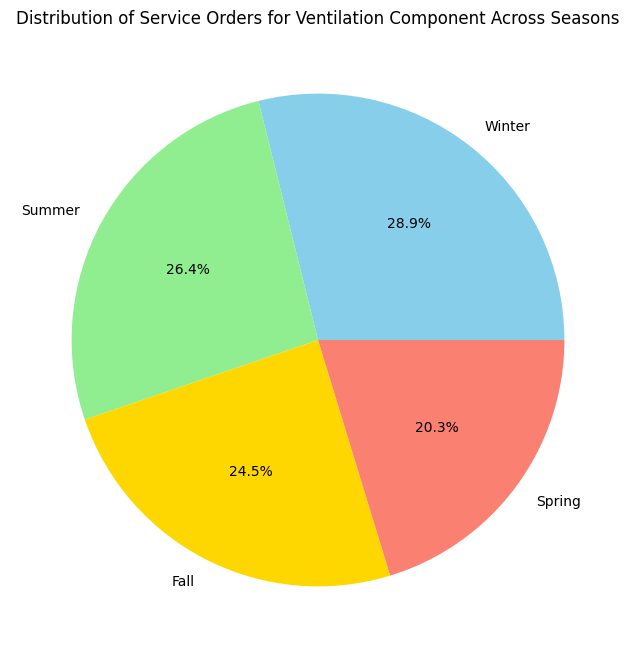

In [ ]:
# Apply the custom function 'get_season' to the 'Month' column to create a new 'Season' column for each ventilation-related service order.
df_so_cleaned_ventilation['Season'] = df_so_cleaned_ventilation['Month'].apply(get_season)

# Counting the occurrences of service orders for each season.
season_counts = df_so_cleaned_ventilation['Season'].value_counts()

# Create a pie chart to visualize the distribution of service orders across different seasons for the ventilation component.
plt.figure(figsize=(8, 8))  # Set the figure size for the plot.
season_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'gold', 'salmon'])  # Plot the data as a pie chart with percentage labels and custom colors.

plt.ylabel('')  # Remove the y-axis label as it is not needed in a pie chart.
plt.title('Distribution of Service Orders for Ventilation Component Across Seasons')  # Set the title of the plot.

# Save the pie chart as a PNG image. Change the output path in case of need!
plt.savefig('/content/drive/MyDrive/Kropman/figures/Frequency/ventilation/seasonal_distribution.png')

plt.show()  # Display the plot.

# ARM

## Obtain Pruned Association Rules

In [ ]:
# Step 1: Split each service order description in the 'SO_Omschrijving' column into individual words for the ventilation component.
transactions_ventilation = df_so_cleaned_ventilation[df_so_cleaned_ventilation['target'] == 'Ventilation']['SO_Omschrijving'].apply(lambda t: t.split(' '))

# Convert the series of lists into a list of transactions (each transaction is a list of words).
transactions_ventilation = list(transactions_ventilation)

# Step 2: Apply one-hot encoding to the transactions using the TransactionEncoder.
encoder_ventilation = TransactionEncoder().fit(transactions_ventilation)  # Fit the encoder to the transactions.
onehot_ventilation = encoder_ventilation.transform(transactions_ventilation)  # Transform the transactions into one-hot encoded form.
onehot_ventilation = pd.DataFrame(onehot_ventilation, columns=encoder_ventilation.columns_)  # Convert the result into a DataFrame.

# Step 3: Define the minimum support threshold for finding frequent itemsets.
'''
Define the minimum number of occurrences for each itemset.
This indirectly acts as a hyperparamether, so tune it as you pefer.
Increase the value of "n" if you want to find more frequent itemsets.
Decrease the value of "n" if you want to find less frequent itemsets.
'''
n = 10
minimum_support = n / len(onehot_ventilation)  # Calculate the minimum support as the ratio of 'n' to the total number of transactions.

# Step 4: Run the Apriori algorithm to identify frequent itemsets based on the minimum support threshold.
frequent_itemsets_ventilation = apriori(onehot_ventilation,
                                        min_support=minimum_support,  # Use the calculated minimum support.
                                        use_colnames=True,  # Keep column names in the output.
                                        verbose=1)  # Show verbose output for progress.

# Step 5: Generate association rules from the frequent itemsets using the 'lift' metric with a minimum threshold of 1.
rules_ventilation = association_rules(frequent_itemsets_ventilation, metric='lift', min_threshold=1)

# Print summary statistics of the process.
print(f'Number of transactions: {len(onehot_ventilation)}')
print(f'Minimum number of occurrences for each itemset: {n}')
print(f'Minimum support threshold for itemsets: {minimum_support}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_ventilation)}')
print(f'Number of rules: {len(rules_ventilation)}\n')

# Step 6: Replace frozen sets with strings for easier readability in the rules.
rules_ventilation['antecedents'] = rules_ventilation['antecedents'].apply(lambda a: ','.join(list(a)))  # Convert antecedents from frozen sets to strings.
rules_ventilation['consequents'] = rules_ventilation['consequents'].apply(lambda a: ','.join(list(a)))  # Convert consequents from frozen sets to strings.

# Display the final association rules.
rules_ventilation

Processing 8 combinations | Sampling itemset size 4
Number of transactions: 592
Minimum number of occurrences for each itemset: 10
Minimum support threshold for itemsets: 0.016891891891891893
Number of frequent itemsets: 59
Number of rules: 36



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,storing,iv,0.298986,0.027027,0.016892,0.056497,2.090395,0.008811,1.031235,0.744096
1,iv,storing,0.027027,0.298986,0.016892,0.625000,2.090395,0.008811,1.869369,0.536111
2,lawaai,maakt,0.027027,0.037162,0.020270,0.750000,20.181818,0.019266,3.851351,0.976852
3,maakt,lawaai,0.037162,0.027027,0.020270,0.545455,20.181818,0.019266,2.140541,0.987135
4,lbk,snaarbreuk,0.331081,0.037162,0.023649,0.071429,1.922078,0.011345,1.036902,0.717172
5,snaarbreuk,lbk,0.037162,0.331081,0.023649,0.636364,1.922078,0.011345,1.839527,0.498246
6,lbk,storing,0.331081,0.298986,0.123311,0.372449,1.245705,0.024322,1.117062,0.294866
7,storing,lbk,0.298986,0.331081,0.123311,0.412429,1.245705,0.024322,1.138449,0.281367
8,urgent,lbk,0.032095,0.331081,0.020270,0.631579,1.907626,0.009644,1.815637,0.491565
9,lbk,urgent,0.331081,0.032095,0.020270,0.061224,1.907626,0.009644,1.031030,0.711279


## Heatmap of support

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


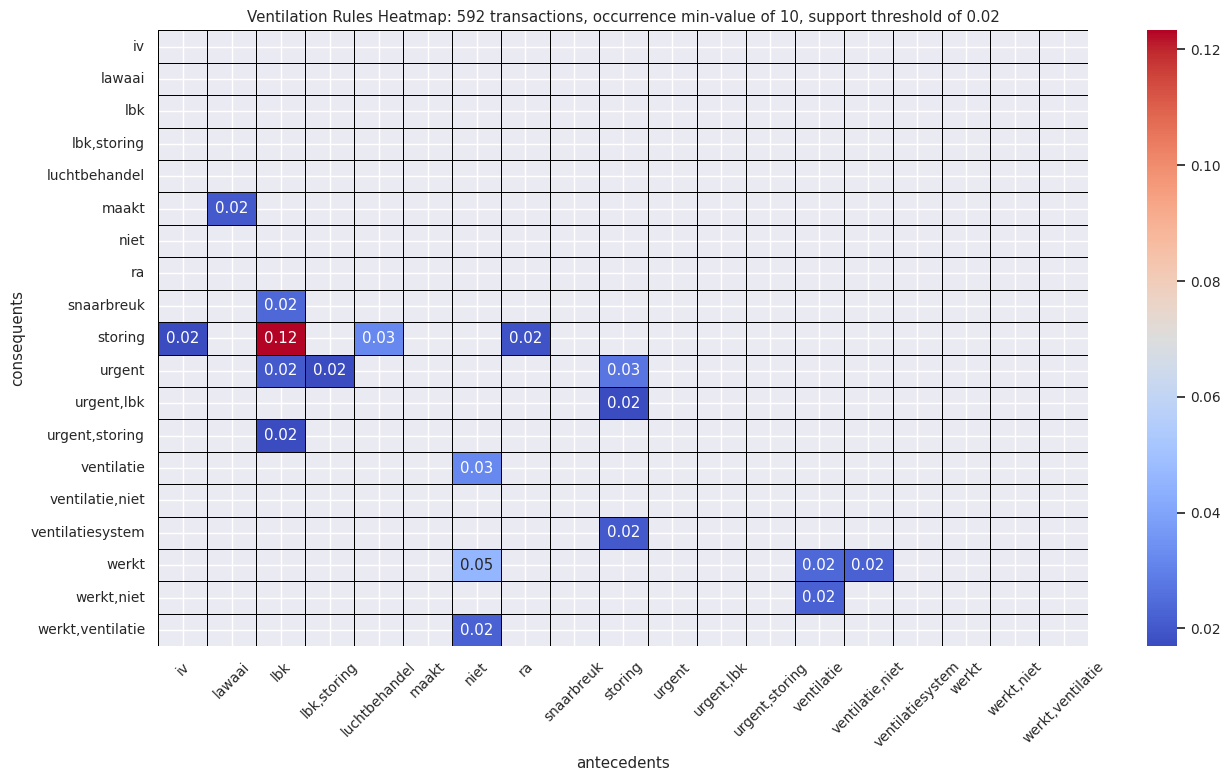

In [ ]:
# Step 1: Transform the association rules data into a pivot table for the heatmap.
# The pivot table uses 'consequents' as the row index and 'antecedents' as the columns, with 'support' values as the matrix.
pivot = rules_ventilation.pivot(index='consequents', columns='antecedents', values='support')

# Step 2: Create a mask for the upper triangle of the heatmap to avoid duplicate values being displayed.
mask = np.triu(np.ones_like(pivot, dtype=bool))

# Step 3: Set the font scale for the heatmap.
sns.set(font_scale=0.9)

# Step 4: Create the heatmap figure.
plt.figure(figsize=(15, 8))

# Step 5: Generate the heatmap using seaborn.
heatmap = sns.heatmap(pivot,  # The pivot table containing support values.
                      cmap='coolwarm',  # Use the 'coolwarm' color palette.
                      mask=mask,  # Apply the mask to hide the upper triangle of the heatmap.
                      cbar=True,  # Show the color bar indicating the support values.
                      linewidths=0.5,  # Set the width of the grid lines.
                      linecolor='black',  # Set the color of the grid lines.
                      annot=True,  # Annotate each cell with the support value.
                      fmt='.2f')  # Format the annotations to two decimal places.

# Step 6: Customize the heatmap.
plt.xticks(rotation=45) # Rotate the x-axis labels 45 degrees for better readability.
plt.title(f'Ventilation Rules Heatmap: {len(onehot_ventilation)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}') # Set the heatmap title.
plt.yticks(rotation=0) # Keep the y-axis labels horizontal.

# Step 7: Save the heatmap as an image file. Change the output path in case of need!
plt.savefig('/content/drive/MyDrive/Kropman/figures/Association Rule Mining/ventilation/support_heatmap.png')

# Step 8: Display the heatmap.
plt.show()

## Heatmap of leverage

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


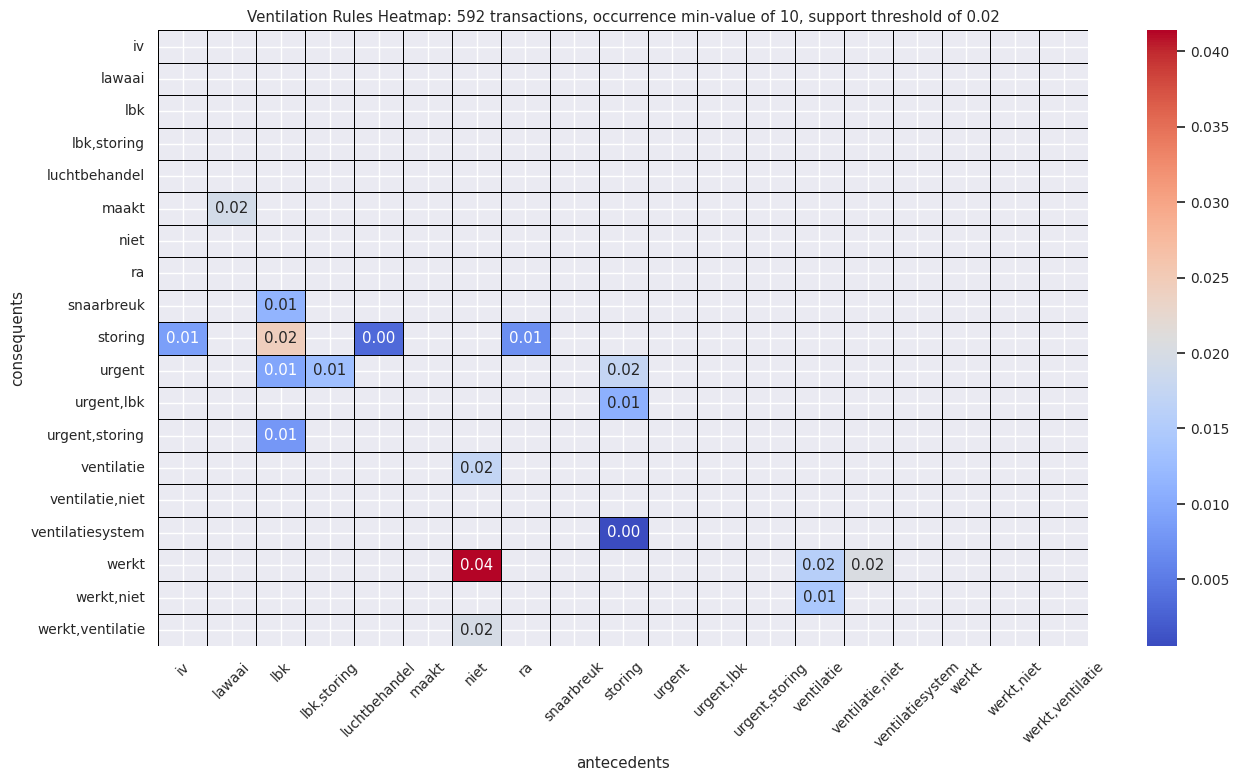

In [ ]:
# Step 1: Transform the association rules data into a pivot table for the heatmap.
# The pivot table uses 'consequents' as the row index and 'antecedents' as the columns, with 'leverage' values as the matrix.
pivot = rules_ventilation.pivot(index='consequents', columns='antecedents', values='leverage')

# Step 2: Create a mask for the upper triangle of the heatmap to avoid duplicate values being displayed.
mask = np.triu(np.ones_like(pivot, dtype=bool))

# Step 3: Set the font scale for the heatmap.
sns.set(font_scale=0.9)

# Step 4: Create the heatmap figure.
plt.figure(figsize=(15, 8))

# Step 5: Generate the heatmap using seaborn.
heatmap = sns.heatmap(pivot,  # The pivot table containing support values.
                      cmap='coolwarm',  # Use the 'coolwarm' color palette.
                      mask=mask,  # Apply the mask to hide the upper triangle of the heatmap.
                      cbar=True,  # Show the color bar indicating the support values.
                      linewidths=0.5,  # Set the width of the grid lines.
                      linecolor='black',  # Set the color of the grid lines.
                      annot=True,  # Annotate each cell with the support value.
                      fmt='.2f')  # Format the annotations to two decimal places.

# Step 6: Customize the heatmap.
plt.xticks(rotation=45) # Rotate the x-axis labels 45 degrees for better readability.
plt.title(f'Ventilation Rules Heatmap: {len(onehot_ventilation)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}') # Set the heatmap title.
plt.yticks(rotation=0) # Keep the y-axis labels horizontal.

# Step 7: Save the heatmap as an image file. Change the output path in case of need!
plt.savefig('/content/drive/MyDrive/Kropman/figures/Association Rule Mining/ventilation/leverage_heatmap.png')

# Step 8: Display the heatmap.
plt.show()

## Heatmap of conviction

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


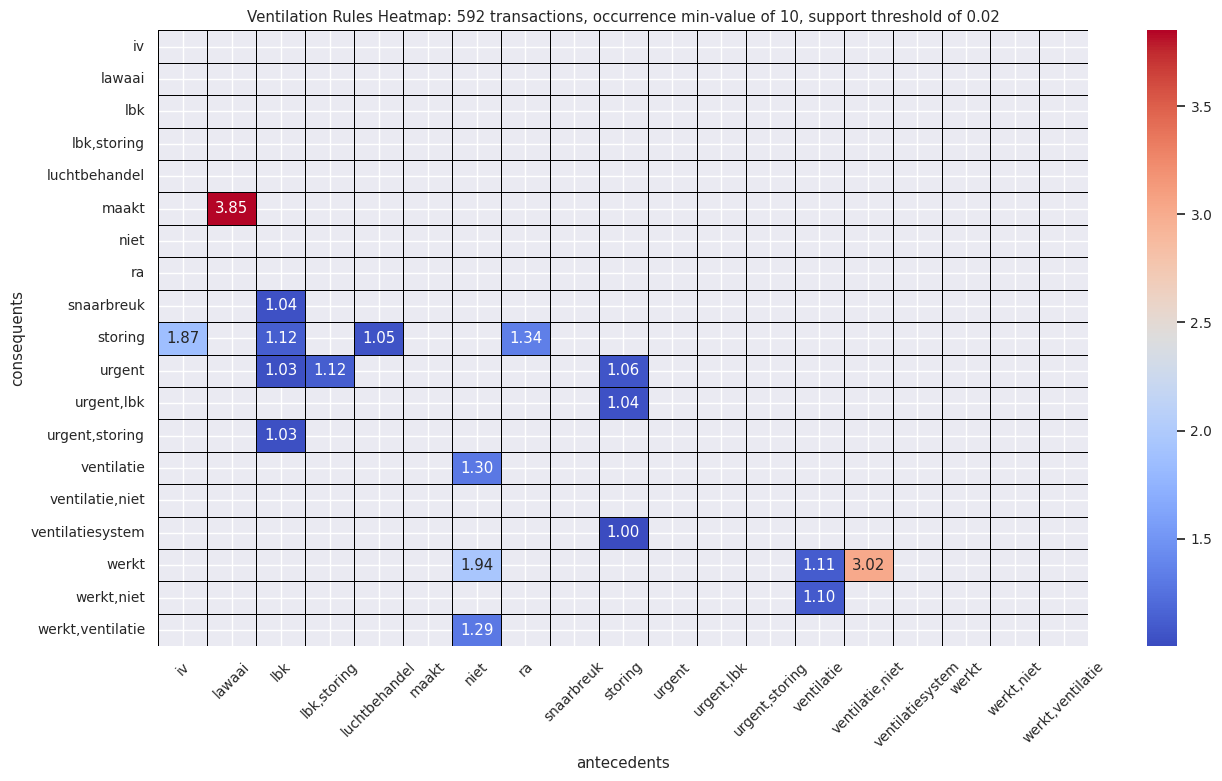

In [ ]:
# Step 1: Transform the association rules data into a pivot table for the heatmap.
# The pivot table uses 'consequents' as the row index and 'antecedents' as the columns, with 'conviction' values as the matrix.
pivot = rules_ventilation.pivot(index='consequents', columns='antecedents', values='conviction')

# Step 2: Create a mask for the upper triangle of the heatmap to avoid duplicate values being displayed.
mask = np.triu(np.ones_like(pivot, dtype=bool))

# Step 3: Set the font scale for the heatmap.
sns.set(font_scale=0.9)

# Step 4: Create the heatmap figure.
plt.figure(figsize=(15, 8))

# Step 5: Generate the heatmap using seaborn.
heatmap = sns.heatmap(pivot,  # The pivot table containing support values.
                      cmap='coolwarm',  # Use the 'coolwarm' color palette.
                      mask=mask,  # Apply the mask to hide the upper triangle of the heatmap.
                      cbar=True,  # Show the color bar indicating the support values.
                      linewidths=0.5,  # Set the width of the grid lines.
                      linecolor='black',  # Set the color of the grid lines.
                      annot=True,  # Annotate each cell with the support value.
                      fmt='.2f')  # Format the annotations to two decimal places.

# Step 6: Customize the heatmap.
plt.xticks(rotation=45) # Rotate the x-axis labels 45 degrees for better readability.
plt.title(f'Ventilation Rules Heatmap: {len(onehot_ventilation)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}') # Set the heatmap title.
plt.yticks(rotation=0) # Keep the y-axis labels horizontal.

# Step 7: Save the heatmap as an image file. Change the output path in case of need!
plt.savefig('/content/drive/MyDrive/Kropman/figures/Association Rule Mining/ventilation/conviction_heatmap.png')

# Step 8: Display the heatmap.
plt.show()

## Frequency table

### Prepare items

In [ ]:
# Step 1: Combine 'antecedents' and 'consequents' of each rule into a single 'itemset' string for easier handling.
rules_ventilation['itemset'] = rules_ventilation.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)

# Step 2: Calculate the absolute count of each itemset's occurrence by multiplying the support value by the total number of transactions.
# The number of transactions is determined by the length of the onehot_ventilation matrix.
rules_ventilation['count'] = rules_ventilation.apply(lambda row: int(row['support'] * len(onehot_ventilation)), axis=1)

# Step 3: Convert the 'itemset' string into a Python set to facilitate further itemset manipulations.
rules_ventilation['itemset'] = rules_ventilation['itemset'].apply(convert_str_to_set)

# Step 4: Format the support values to three decimal places and store them in a new column 'rounded_support'.
rules_ventilation['rounded_support'] = rules_ventilation.apply(lambda row: f"{row['support']:.3f}", axis=1)

# Step 5: Calculate the percentage occurrence of each itemset and format the result with two decimal places and a '%' symbol.
rules_ventilation['percentage'] = rules_ventilation.apply(lambda row: f"{row['count'] * 100 / len(onehot_ventilation):.2f}%", axis=1)

# Step 6: Round the conviction values to three decimal places and store them in a new column 'rounded_conviction' for easier reading.
rules_ventilation['rounded_conviction'] = rules_ventilation.apply(lambda row: f"{row['conviction']:.3f}", axis=1)

# Step 7: Sort the DataFrame based on conviction values in descending order to prioritize rules with higher conviction.
rules_ventilation.sort_values(by='conviction', ascending=False, inplace=True)

# Step 8: Remove duplicate itemsets based on the 'itemset' column, keeping only the first occurrence.
rules_ventilation.drop_duplicates(subset=['itemset'], keep='first', inplace=True)

# Step 9: Reset the index of the DataFrame to maintain consistency after sorting and dropping duplicates.
rules_ventilation.reset_index(inplace=True)

# Output the final processed DataFrame.
rules_ventilation

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,itemset,count,rounded_support,percentage,rounded_conviction
0,14,werkt,niet,0.047297,0.089527,0.045608,0.964286,10.770889,0.041374,25.493243,0.952193,"{werkt, niet}",27,0.046,4.56%,25.493
1,30,"werkt,ventilatie",niet,0.023649,0.089527,0.021959,0.928571,10.371968,0.019842,12.746622,0.925472,"{werkt, ventilatie, niet}",13,0.022,2.20%,12.747
2,18,urgent,storing,0.032095,0.298986,0.027027,0.842105,2.816533,0.017431,4.439752,0.666339,"{urgent, storing}",16,0.027,2.70%,4.440
3,24,"urgent,lbk",storing,0.020270,0.298986,0.016892,0.833333,2.787194,0.010831,4.206081,0.654483,"{urgent, lbk, storing}",10,0.017,1.69%,4.206
4,2,lawaai,maakt,0.027027,0.037162,0.020270,0.750000,20.181818,0.019266,3.851351,0.976852,"{lawaai, maakt}",12,0.020,2.03%,3.851
5,1,iv,storing,0.027027,0.298986,0.016892,0.625000,2.090395,0.008811,1.869369,0.536111,"{storing, iv}",10,0.017,1.69%,1.869
6,5,snaarbreuk,lbk,0.037162,0.331081,0.023649,0.636364,1.922078,0.011345,1.839527,0.498246,"{lbk, snaarbreuk}",14,0.024,2.36%,1.840
7,8,urgent,lbk,0.032095,0.331081,0.020270,0.631579,1.907626,0.009644,1.815637,0.491565,"{urgent, lbk}",12,0.020,2.03%,1.816
8,22,werkt,ventilatie,0.047297,0.165541,0.023649,0.500000,3.020408,0.015819,1.668919,0.702128,"{werkt, ventilatie}",14,0.024,2.36%,1.669
9,17,ra,storing,0.038851,0.298986,0.018581,0.478261,1.599607,0.006965,1.343609,0.389998,"{storing, ra}",11,0.019,1.86%,1.344


### Show Ventilation Rules

In [ ]:
# Sort values by 'support' column.
rules_ventilation.sort_values(by='support', ascending=False, inplace=True)

# Add the index as a column.
rules_ventilation.reset_index(inplace=True)
rules_ventilation.rename(columns={'index': 'index'}, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


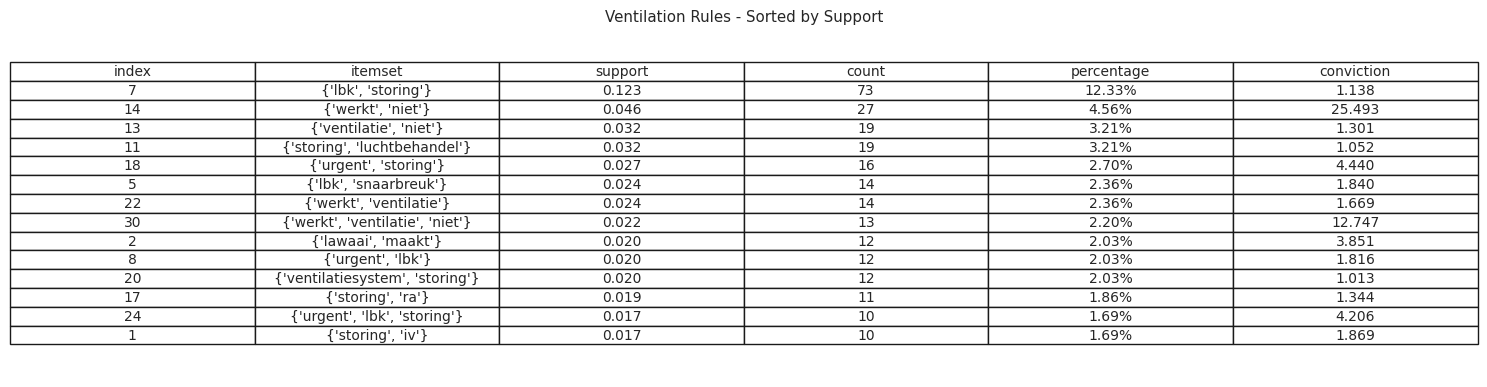

In [ ]:
# Step 1: Create a matplotlib subplot with specific figure size (15x4 inches).
fig, ax = plt.subplots(figsize=(15, 4))

# Step 2: Turn off the axis display to avoid showing the axis lines and labels.
ax.axis('tight')
ax.axis('off')

# Step 3: Specify the columns from 'rules_ventilation' that will be displayed in the table.
columns_to_include = ['index', 'itemset', 'rounded_support', 'count', 'percentage', 'rounded_conviction']

# Step 4: Create a table in the plot using the specified columns and values from 'rules_ventilation'.
# The 'cellText' argument contains the values from the columns, and 'colLabels' provides the column headers.
table = ax.table(cellText=rules_ventilation[columns_to_include].values,
                 colLabels=rules_ventilation[['index', 'itemset', 'support', 'count', 'percentage', 'conviction']].columns,
                 cellLoc='center', loc='center')

# Step 5: Disable automatic font size adjustments for the table to maintain a fixed font size.
table.auto_set_font_size(False)

# Step 6: Set the font size for the table to 10 for better readability.
table.set_fontsize(10)

# Step 7: Add a title to the plot indicating that the table contains ventilation rules sorted by support.
plt.title('Ventilation Rules - Sorted by Support')

# Step 8: Adjust the layout of the plot to prevent any overlap and ensure the table fits neatly within the figure.
plt.tight_layout()

# Step 9: Save the figure to the specified file path as a PNG image with tight bounding box adjustments.
# Change the saving path in case of need!
plt.savefig('/content/drive/MyDrive/Kropman/figures/Association Rule Mining/ventilation/itemsets_frequency_table.png', bbox_inches='tight')

# Step 10: Display the plot containing the table.
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


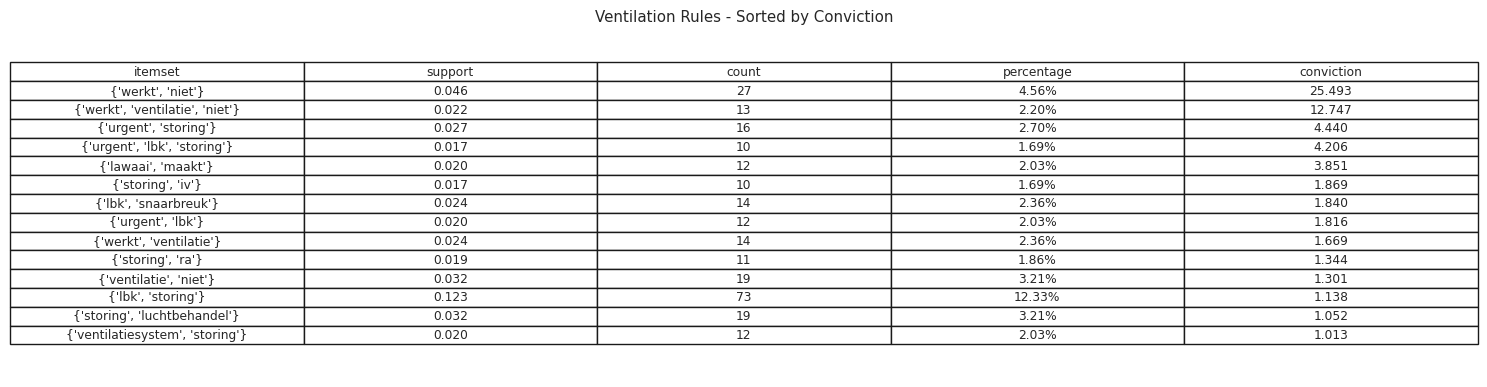

In [ ]:
# Step 1: Sort the 'rules_ventilation' DataFrame in descending order by the 'conviction' column.
rules_ventilation.sort_values(by='conviction', ascending=False, inplace=True)

# Step 2: Create a matplotlib subplot with a figure size of 15x4 inches.
fig, ax = plt.subplots(figsize=(15, 4))

# Step 3: Turn off the axis display to hide axis lines and labels.
ax.axis('tight')
ax.axis('off')

# Step 4: Create a table using the sorted 'rules_ventilation' DataFrame.
# The table will display the columns 'itemset', 'rounded_support', 'count', 'percentage', and 'rounded_conviction'.
# The 'colLabels' argument provides the actual column names, and 'cellText' contains the corresponding values.
table = ax.table(cellText=rules_ventilation[['itemset', 'rounded_support', 'count', 'percentage', 'rounded_conviction']].values,
         colLabels=rules_ventilation[['itemset', 'support', 'count', 'percentage', 'conviction']].columns,
         cellLoc='center', loc='center', fontsize=15)  # Set table cell font size to 15.

# Step 5: Set the title of the table plot, indicating that the rules are sorted by conviction.
plt.title('Ventilation Rules - Sorted by Conviction')

# Step 6: Adjust the layout to prevent any overlap and ensure the table fits within the figure dimensions.
plt.tight_layout()

# Step 7: Display the table plot.
plt.show()